# What Is The Best Position To Draft In Fantasy Football

> By: Ayush Desai, Noah Grinspoon, and Dawson Metzger-Fleetwood


# Introduction


Fantasy football was first invented in 1962 by Bill Winkenbach, a part-owner of the Oakland Raiders football team, when he gathered with some friends in a New York City hotel and created the first fantasy football league. Fast forward 60 years and now fantasy football has become one of the biggest games in the world with over 40 million players each year and generating over $18 million per year. While fantasy football has grown exponentially, its original concept remains largely the same. You can read more about the history of fantasy football here: https://en.wikipedia.org/wiki/Fantasy_football_(gridiron)#History

A fantasy league typically contains around 10 users who manage a roster consisting of 1 quarterback (QB), 2 running backs (RB), 2 wide receivers (WR), a tight end (TE), a flex spot that can be filled by an additional running back, wide receiver, or tight end, a kicker, and a defense. Each user competes head-to-head against 1 other user in the league each week, and tries to get more points than that user. At the end of the week, the user with the most points “wins” that week’s matchup. Whoever has the most matchup wins at the end of the season is the winner. In a given week’s matchup, the way users earn points is based on how the user’s players perform in real games. Scoring is done using a point system. Each point earned, or lost, is called a “Fantasy Point”. Scoring typically works by rewarding players for good plays like passing for a touchdown (4 points), throwing yards (1 point for every 25 yards), and punishing players for bad plays like throwing an interception (-2 points). Users get players through a draft similar to the NFL. The users go one by one picking a player for their team. At the end of each round of picks (every player picks once), the players go again but in reverse order. This is repeated till the end of the 15th round where users can then adjust their lineups. You can read more about how fantasy football works here: https://www.nfl.com/news/how-to-play-fantasy-football-a-beginner-s-guide-0ap3000000692955

In our project, we wanted to use data science and machine learning to help users pick better players for their fantasy teams. Every year, the consensus is that the best position to take first is a running back; however, we wanted to make sure of this. In this project, we will analyze QBs, RBs, WRs, and TEs to determine if running backs are the best position to pick first. We will also analyze past performances of these positions to create a model that can help us choose good players for our team. This model will predict if a player will be one of the top scorers in fantasy points next season for that position.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm
import statsmodels.api as sm
from sklearn import tree
from sklearn.model_selection import train_test_split

# Data Curation, Parsing, and Management


The first thing we did was access 5 CSV files containing data for all players from 2015 to 2019. The data sets contain each player’s stats, games played and started, age, position, and most importantly their total fantasy points for the entire year. Since we want to look at the players that score the most fantasy points, we stored each CSV file into an array and then went through each year and sorted all players by their total fantasy points.


In [2]:
stats = []
for i in range(2015,2020):
  string = "AllData/" + str(i) + ".csv"
  stats.append(pd.read_csv(string))

#sorts all the years data by fantasy points
for i in range(len(stats)):
    stats[i] = stats[i].sort_values(['FantasyPoints', 'FantasyPoints'], ascending=[False,False])

print("Player data from 2015:")
stats[0].head()

Player data from 2015:


,Unnamed: 0,Player,Tm,Pos,Age,G,GS,Cmp,Att,Yds,...,FumblesLost,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,FantasyPoints
4,4,Cam Newton,CAR,QB,26.0,16.0,16.0,296.0,495.0,3837.0,...,4.0,3837.0,35.0,495.0,636.0,10.0,132.0,0.0,0.0,389.08
0,0,Antonio Brown,PIT,WR,27.0,16.0,16.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,28.0,0.0,3.0,1834.0,10.0,378.20
2,2,Julio Jones,ATL,WR,26.0,16.0,16.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1871.0,8.0,369.10
20,20,Tom Brady,NWE,QB,38.0,16.0,16.0,402.0,624.0,4770.0,...,2.0,4770.0,36.0,624.0,53.0,3.0,34.0,36.0,0.0,344.70
5,5,Brandon Marshall,NYJ,WR,31.0,16.0,16.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1502.0,14.0,339.20




Now that we have our data sorted, we want to create a way to determine the value of each player since there are a number of factors that determine how good a player is in fantasy football and will help us later to create our predictor. We created a formula to appropriately determine this. The formula is as follows: the total points scored in a season/16 (number of games in a season) + (the prime age of a position - the player’s current age)/the prime age of a position + the number of games played by the player/4.


In [3]:
#a counter so we are making sure we are only looking at a certain amount of each position
def reset_counter():
    return {'RB' : 0, 'QB' : 0, 'WR' : 0, 'TE' : 0}

data = {}
#the peak ages of each position according to google
prime_age_per_pos = {'RB' : 27, 'QB' : 29, 'WR' : 26, 'TE' : 28}
#the amout of each position we want to see
counter_cap = {'RB' : 30, 'QB' : 10, 'WR' : 30, 'TE' : 20}
counters = reset_counter()
#goes through each year and generates a value for each player
#this value is calculated by doing total fantasy points/16+(difference from prime)/16+games played/4
for i in range(len(stats)):
    stats[i]['Value'] = -1.0
    for j,row in stats[i].iterrows():
        pos = row['Pos']
        age = row['Age']
        games_played = row['G']
        points_per_season = row['FantasyPoints']/16
        
        if pos != 'K' and pos != '0' and counters[pos] < counter_cap[pos]:
            counters[pos] += 1
            stats[i].at[j, 'Value'] = points_per_season + (prime_age_per_pos[pos] - age)/prime_age_per_pos[pos] + games_played/4
            
    counters = reset_counter()


In [4]:
#gets the data from each year that we calculated values for and removes any rows that we did not calculate values for
cutoff_stats = stats.copy()
for i in range(len(cutoff_stats)):
    cutoff_stats[i] = cutoff_stats[i][cutoff_stats[i].Value != -1]
    cutoff_stats[i] = cutoff_stats[i].sort_values(['Value', 'Value'], ascending=[False,False])

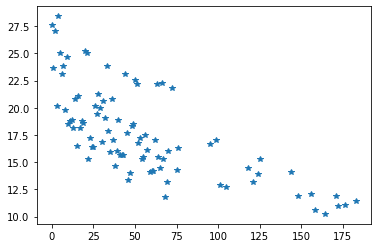

In [5]:
plt.plot(cutoff_stats[0]["Value"], "*");

In [6]:
cutoff_stats[0].head()

,Unnamed: 0,Player,Tm,Pos,Age,G,GS,Cmp,Att,Yds,...,PassingYds,PassingTD,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,FantasyPoints,Value
4,4,Cam Newton,CAR,QB,26.0,16.0,16.0,296.0,495.0,3837.0,...,3837.0,35.0,495.0,636.0,10.0,132.0,0.0,0.0,389.08,28.420948
0,0,Antonio Brown,PIT,WR,27.0,16.0,16.0,0.0,0.0,0.0,...,0.0,0.0,0.0,28.0,0.0,3.0,1834.0,10.0,378.20,27.599038
2,2,Julio Jones,ATL,WR,26.0,16.0,16.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1871.0,8.0,369.10,27.068750
20,20,Tom Brady,NWE,QB,38.0,16.0,16.0,402.0,624.0,4770.0,...,4770.0,36.0,624.0,53.0,3.0,34.0,36.0,0.0,344.70,25.233405
21,21,Russell Wilson,SEA,QB,27.0,16.0,16.0,329.0,483.0,4024.0,...,4024.0,34.0,483.0,553.0,1.0,103.0,0.0,0.0,336.26,25.085216


# Exploratory Data Analysis
Now that we have a way to determine how good a fantasy player’s performance is in a season, we can start looking at the different positions and their values. The first thing we do is sort the values into their respective positions (QB, RB, WR, and TE) so we can look at how valuable each position truly is and where it's best to draft them.


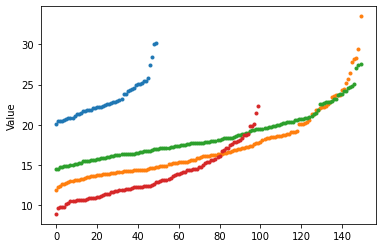

In [7]:
QB_values = []
RB_values = []
WR_values = []
TE_values = []
for i in range(len(cutoff_stats)):
  curr = cutoff_stats[i]
  for j,row in curr.iterrows():
    if row["Pos"] == "QB":
      QB_values.append(float(row["Value"]))
    elif row["Pos"] == "RB":
      RB_values.append(float(row["Value"]))
    elif row["Pos"] == "WR":
      WR_values.append(float(row["Value"]))
    elif row["Pos"] == "TE":
      TE_values.append(float(row["Value"]))


QB_values = np.sort(QB_values)
# plt.legend(["QB"])
RB_values = np.sort(RB_values)
WR_values = np.sort(WR_values)
TE_values = np.sort(TE_values)
plt.plot(QB_values,".");
plt.plot(RB_values,".");
plt.plot(WR_values,".");
plt.plot(TE_values,".");
plt.ylabel("Value")
plt.show()

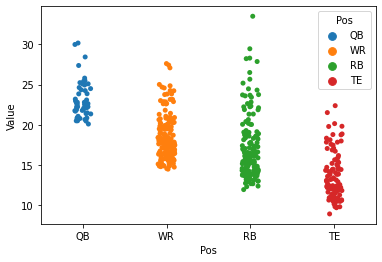

In [8]:
all_stats = cutoff_stats[0]
for i in range(1,len(cutoff_stats)):
  all_stats = all_stats.append(cutoff_stats[i])
sb.stripplot(x="Pos",y="Value",data=all_stats,jitter=True,hue='Pos');

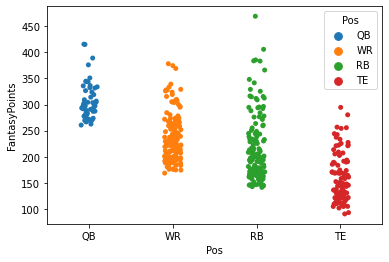

In [9]:
sb.stripplot(x="Pos",y="FantasyPoints",data=all_stats,jitter=True,hue='Pos');

When we plot these points we can see that QBs tend to have higher values followed by WRs, RBs, and lastly TEs. Looking at this data, it would make sense to pick a QB first since they have a higher value.
However, when we plot all the values on a bell curve and see their stats, we see a much different story.


QB Values for the Top 10 QBs:
mean: 23.130953448275864
median: 22.537693965517242
standard deviation: 2.3210430610340254
range: 10.049741379310344


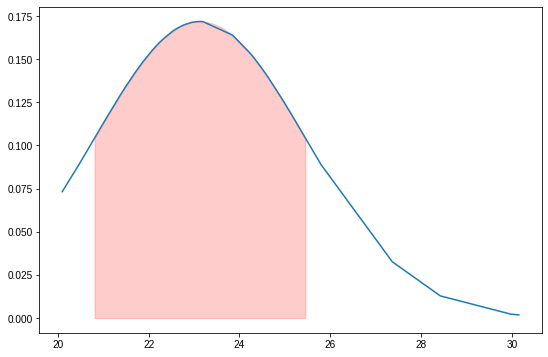

In [10]:
print("QB Values for the Top 10 QBs:")
print("mean: "+str(np.mean(QB_values)))
print("median: "+str(np.median(QB_values)))
print("standard deviation: "+str(np.std(QB_values)))
print("range: "+str(np.ptp(QB_values)))
y = norm.pdf(QB_values,np.mean(QB_values),np.std(QB_values))
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(QB_values,y)
x_fill = np.arange(np.mean(QB_values)-np.std(QB_values), np.mean(QB_values)+np.std(QB_values), 0.001)
y_fill = norm.pdf(x_fill,np.mean(QB_values),np.std(QB_values))
ax.fill_between(x_fill,y_fill,0, alpha=0.2, color='red')
plt.style.use('seaborn')
plt.show()

RB Values for the Top 30 RBs:
mean: 17.221903086419754
median: 16.155787037037037
standard deviation: 3.953880252647174
range: 21.51064814814815


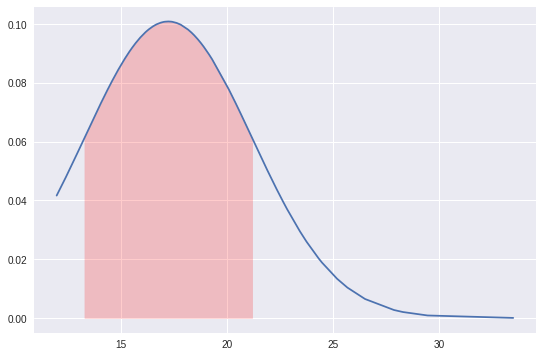

In [11]:
print("RB Values for the Top 30 RBs:")
print("mean: "+str(np.mean(RB_values)))
print("median: "+str(np.median(RB_values)))
print("standard deviation: "+str(np.std(RB_values)))
print("range: "+str(np.ptp(RB_values)))
y = norm.pdf(RB_values,np.mean(RB_values),np.std(RB_values))
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(RB_values,y)
x_fill = np.arange(np.mean(RB_values)-np.std(RB_values), np.mean(RB_values)+np.std(RB_values), 0.001)
y_fill = norm.pdf(x_fill,np.mean(RB_values),np.std(RB_values))
ax.fill_between(x_fill,y_fill,0, alpha=0.2, color='red')
plt.style.use('seaborn')
plt.show()

WR Values for the Top 30 WRs:
mean: 18.627566025641023
median: 17.89951923076923
standard deviation: 2.861068577359882
range: 13.099999999999998


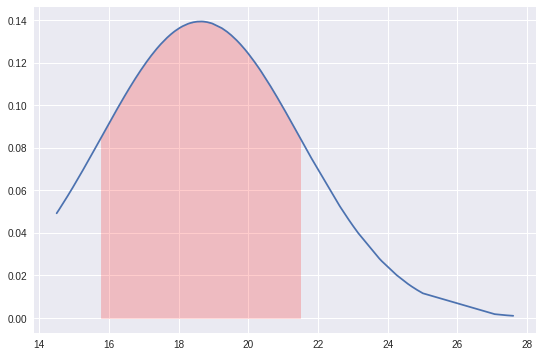

In [12]:
print("WR Values for the Top 30 WRs:")
print("mean: "+str(np.mean(WR_values)))
print("median: "+str(np.median(WR_values)))
print("standard deviation: "+str(np.std(WR_values)))
print("range: "+str(np.ptp(WR_values)))
y = norm.pdf(WR_values,np.mean(WR_values),np.std(WR_values))
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(WR_values,y)
x_fill = np.arange(np.mean(WR_values)-np.std(WR_values), np.mean(WR_values)+np.std(WR_values), 0.001)
y_fill = norm.pdf(x_fill,np.mean(WR_values),np.std(WR_values))
ax.fill_between(x_fill,y_fill,0, alpha=0.2, color='red')
plt.style.use('seaborn')
plt.show()

TE Values for the Top 20 TEs:
mean: 13.660160714285716
median: 12.93705357142857
standard deviation: 2.930962476053415
range: 13.43214285714286


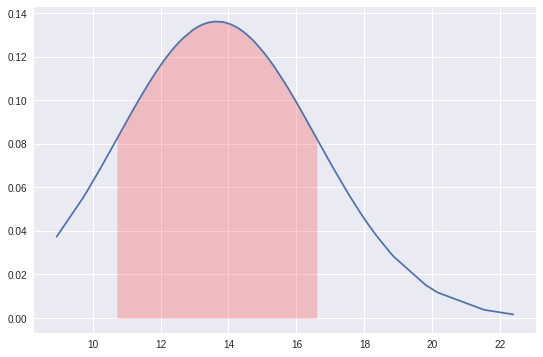

In [13]:
print("TE Values for the Top 20 TEs:")
print("mean: "+str(np.mean(TE_values)))
print("median: "+str(np.median(TE_values)))
print("standard deviation: "+str(np.std(TE_values)))
print("range: "+str(np.ptp(TE_values)))
y = norm.pdf(TE_values,np.mean(TE_values),np.std(TE_values))
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(TE_values,y)
x_fill = np.arange(np.mean(TE_values)-np.std(TE_values), np.mean(TE_values)+np.std(TE_values), 0.001)
y_fill = norm.pdf(x_fill,np.mean(TE_values),np.std(TE_values))
ax.fill_between(x_fill,y_fill,0, alpha=0.2, color='red')
plt.style.use('seaborn')
plt.show()

Comparing our data once again, we see that QBs lead in the highest average value, but the range of values and standard deviation of values is the smallest among all the positions. Meaning there are a lot of QBs with good values.
Now that we can see there are several good options at QB, let’s look at the other positions. When we look at the other positions we can see that TEs have the lowest average values, the standard deviation of values, and range of values. Meaning that most TEs aren’t very valuable to our team and the few very valuable TEs aren’t very valuable.
Finally, let’s compare the two skill positions: WR and RB. WR and RB have very similar numbers in terms of average value to a team. However, RBs have a higher standard deviation and higher range compared to WRs. This means that there are more middle-of-the-pack RBs and less very valuable RBs compared to WRs. Also, the high range shows that the best RBs are more valuable than the most valuable WRs and the same for the opposite.

# Hypothesis Testing and Machine Learning

## DATA CURATION
We wanted as much data as possible to train our models for making predictions, so we used data going back to 1970. Our fundamental goal is to be able to predict the fantasy points a player will earn this year, given that player’s performance stats from last year. To do this, we need to add some new columns to our data – one for the year, and one for next year’s fantasy points score. If a player does not have a fantasy score for the next year, a sentinel value will be added instead.


In [14]:
data = []
for i in range(1970,2020):
  string = "AllData/" + str(i) + ".csv"
  data.append(pd.read_csv(string))
for i in range(0,len(data)):
  data[i]["Year"] = 1970 + i

all_data = data[0]
for i in range(1,len(data)):
  all_data = all_data.append(data[i])

all_data = all_data.sort_values(["Player", "Year"], ascending=[True,True])

count = 0
indexes = []
all_data["Index"] = 0
for i,row in all_data.iterrows():
  indexes.append(count)
  count += 1
all_data["Index"] = indexes
all_data = all_data.set_index("Index")
all_data = all_data.drop(columns="Unnamed: 0")

all_data["NextYearFP"] = -1000.0
for i in range(0,len(all_data)-1):
  if all_data["Player"][i] == all_data["Player"][i+1]:
    all_data["NextYearFP"][i] = all_data["FantasyPoints"][i+1]

all_data = all_data[all_data.NextYearFP != -1000.0]


count = 0
indexes = []
all_data["Index"] = 0
for i,row in all_data.iterrows():
  indexes.append(count)
  count += 1
all_data["Index"] = indexes
all_data = all_data.set_index("Index")

QB_data = all_data[all_data.Pos == "QB"]
RB_data = all_data[all_data.Pos == "RB"]
WR_data = all_data[all_data.Pos == "WR"]
TE_data = all_data[all_data.Pos == "TE"]

<ipython-input-14-2f0031d27c09>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data["NextYearFP"][i] = all_data["FantasyPoints"][i+1]


## REGRESSION
To predict a player’s fantasy points, we begin by creating a regression model. Since we are analyzing four positions, and each position has drastically different roles on a football team, there is a possibility of there being different useful predictors for each position. For this reason, we will create four regression models, one for each position. These regression models will take in a variety of variables from one season – such as passing yards, rushing touchdowns, games played, etc – and return the number of fantasy points a player with those stats is expected to receive in the next season. 

In [15]:
x = QB_data[['PassingYds', 'RushingYds', 'G', 'Age', 'Int']]
y = QB_data['NextYearFP']
QB_reg = sm.OLS(y, x).fit()

x = RB_data[['ReceivingYds', 'RushingYds', 'G', 'Age', 'Fumbles']]
y = RB_data['NextYearFP']
RB_reg = sm.OLS(y, x).fit()

x = WR_data[['ReceivingYds', 'RushingYds', 'G', 'Age', 'Fumbles']]
y = WR_data['NextYearFP']
WR_reg = sm.OLS(y, x).fit()

x = TE_data[['ReceivingYds', 'Age', 'Fumbles']]
y = TE_data['NextYearFP']
TE_reg = sm.OLS(y, x).fit()

To create the regression models, we began by including one of the predictors that might be relevant to predicting fantasy points for that position. For example, the fantasy points a quarterback gets could come from passing yards, passing touchdowns, and rushing yards. However, quarterbacks hardly ever receive the football, so including receiving yards would be unnecessary. After creating this initial model, we added predictors one by one. After each predictor was added, we checked the p-values and model fit (R^2 and adjusted R^2) to determine if the model with the new predictor was an improvement over the old model.
One of the biggest issues here is multicollinearity. Many of the potential predictors are correlated with each other. An example of this is passing yards and passing touchdowns. The more passing yards a quarterback has, the more passing touchdowns they have as well. Because the predictors in a regression model should not be linearly related to each other, we had to exclude predictors to avoid multicollinearity. 


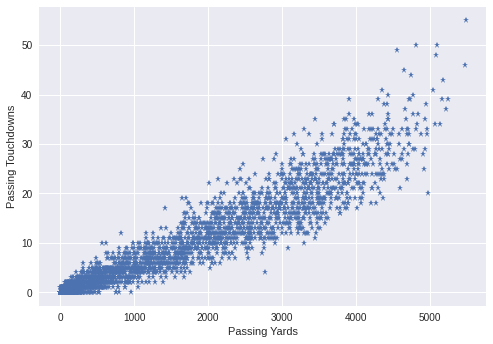

These two predictors should not be used together in a regression model,
 because they are linearly related to each other


In [16]:
plt.plot(QB_data["PassingYds"],QB_data["PassingTD"],"*");
plt.xlabel("Passing Yards")
plt.ylabel("Passing Touchdowns")
plt.show()
print("These two predictors should not be used together in a regression model,\n \
because they are linearly related to each other")

These regression models were remarkably successful in predicting player scores. The R^2 was around 70% for each of the models, indicating that 70% of the variation in a player’s fantasy points next year could be explained with the predictors we had chosen. 

In [17]:
print("QB Regression Summary")
print(QB_reg.summary())
print("\n\n\n\n\n\n\n\n\nRB Regression Summary")
print(RB_reg.summary())
print("\n\n\n\n\n\n\n\n\nWR Regression Summary")
print(WR_reg.summary())
print("\n\n\n\n\n\n\n\n\nTE Regression Summary")
print(TE_reg.summary())

QB Regression Summary
                                 OLS Regression Results                                
Dep. Variable:             NextYearFP   R-squared (uncentered):                   0.707
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              1460.
Date:                Mon, 20 Dec 2021   Prob (F-statistic):                        0.00
Time:                        20:17:02   Log-Likelihood:                         -17092.
No. Observations:                3028   AIC:                                  3.419e+04
Df Residuals:                    3023   BIC:                                  3.422e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

However, there was one huge problem; the regression model was unable to predict outlier performance. Even by making a prediction with the most extreme variable inputs, the predicted fantasy point score was significantly lower than the highest-scoring players in fantasy points. This makes sense, as regression deals with averages. But we want to be able to identify the very best players next season, so a user can add them to their roster. 

# Decision Tree

To combat this, we will train a classifier. We will separate the data into two categories: “Good” and “Bad”. A player is “Good” if their fantasy points next year are in the top 5% of fantasy points for that position, and “Bad ”otherwise. If this classifier is accurate, we will be able to use a player’s stats from this year to predict if they will be in the top 5% of fantasy point scoring players next year. Below I have trained a decision tree classifier for each of the four positions. I have displayed some interesting facts about the data, as well as a rough sketch of the decision tree for the quarterback position. 

In [18]:
def treeAccuracy(topXpercent, testSize, all_data, display):

  QB_data = all_data[all_data.Pos == "QB"]
  RB_data = all_data[all_data.Pos == "RB"]
  WR_data = all_data[all_data.Pos == "WR"]
  TE_data = all_data[all_data.Pos == "TE"]

  temp = QB_data["FantasyPoints"]
  temp = np.sort(temp)
  temp = temp[::-1]
  QB_cutoff = round(len(temp)/(100/topXpercent))
  QB_value = temp[QB_cutoff]

  temp = RB_data["FantasyPoints"]
  temp = np.sort(temp)
  temp = temp[::-1]
  RB_cutoff = round(len(temp)/(100/topXpercent))
  RB_value = temp[RB_cutoff]

  temp = WR_data["FantasyPoints"]
  temp = np.sort(temp)
  temp = temp[::-1]
  # topXpercent = 5
  WR_cutoff = round(len(temp)/(100/topXpercent))
  WR_value = temp[WR_cutoff]

  temp = TE_data["FantasyPoints"]
  temp = np.sort(temp)
  temp = temp[::-1]
  # topXpercent = 5
  TE_cutoff = round(len(temp)/(100/topXpercent))
  TE_value = temp[TE_cutoff]

  classification = []
  for i in range(0,len(all_data)):
    # QB
    if all_data["Pos"][i] == "QB" and all_data["NextYearFP"][i] >= QB_value:
      classification.append("Good")
    # RB
    elif all_data["Pos"][i] == "RB" and all_data["NextYearFP"][i] >= RB_value:
      classification.append("Good")
    # WR
    elif all_data["Pos"][i] == "WR" and all_data["NextYearFP"][i] >= WR_value:
      classification.append("Good")
    # TE
    elif all_data["Pos"][i] == "TE" and all_data["NextYearFP"][i] >= TE_value:
      classification.append("Good")
    # Else
    else:
      classification.append("Bad")
    

  all_data["Classification"] = classification

  QB_data = all_data[all_data.Pos == "QB"]
  RB_data = all_data[all_data.Pos == "RB"]
  WR_data = all_data[all_data.Pos == "WR"]
  TE_data = all_data[all_data.Pos == "TE"]

  X = RB_data[['RushingTD', 'RushingYds', 'G', 'Age', 'Fumbles', 'FantasyPoints']]
  y = RB_data['Classification']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=0)
  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X_train, y_train)
  # tree.plot_tree(clf);
  RB_score = clf.score(X_test, y_test)

  X = WR_data[['ReceivingYds', 'RushingYds', 'ReceivingTD', 'RushingTD', 'G', 'Age', 'Fumbles', 'FantasyPoints']]
  y = WR_data['Classification']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=0)
  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X_train, y_train)
  # tree.plot_tree(clf);
  WR_score = clf.score(X_test, y_test)

  X = TE_data[['ReceivingYds', 'RushingYds', 'ReceivingTD', 'RushingTD', 'G', 'Age', 'Fumbles', 'FantasyPoints']]
  y = TE_data['Classification']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=0)
  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X_train, y_train)
  # tree.plot_tree(clf);
  TE_score = clf.score(X_test, y_test)
    
  X = QB_data[['PassingYds', 'PassingTD', 'RushingYds', 'RushingTD', 'G', 'Age', 'Int', 'FantasyPoints']]
  y = QB_data['Classification']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=0)
  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X_train, y_train)
#   tree.plot_tree(clf);
  QB_score = clf.score(X_test, y_test)

  if display == True:
    print("The top " + str(topXpercent) + "% of QBs since 1970 had a Fantasy Point\
 rating of at least " + str(temp[QB_cutoff]) + ",\nand there were " + str(QB_cutoff)\
          + " of them in total.\n")
    print("The top " + str(topXpercent) + "% of RBs since 1970 had a Fantasy Point\
 rating of at least " + str(temp[RB_cutoff]) + ",\nand there were " + str(RB_cutoff)\
  + " of them in total.\n")
    print("The top " + str(topXpercent) + "% of WRs since 1970 had a Fantasy Point\
 rating of at least " + str(temp[WR_cutoff]) + ",\nand there were " + str(WR_cutoff)\
  + " of them in total.\n")
    print("The top " + str(topXpercent) + "% of TEs since 1970 had a Fantasy Point\
 rating of at least " + str(temp[TE_cutoff]) + ",\nand there were " + str(TE_cutoff)\
  + " of them in total.\n")
    print("QB Decision Tree:")
    tree.plot_tree(clf);
  
  return [QB_score, RB_score, WR_score, TE_score]

The top 5% of QBs since 1970 had a Fantasy Point rating of at least 170.3,
and there were 151 of them in total.

The top 5% of RBs since 1970 had a Fantasy Point rating of at least 139.4,
and there were 301 of them in total.

The top 5% of WRs since 1970 had a Fantasy Point rating of at least 139.1,
and there were 302 of them in total.

The top 5% of TEs since 1970 had a Fantasy Point rating of at least 168.7,
and there were 165 of them in total.

QB Decision Tree:


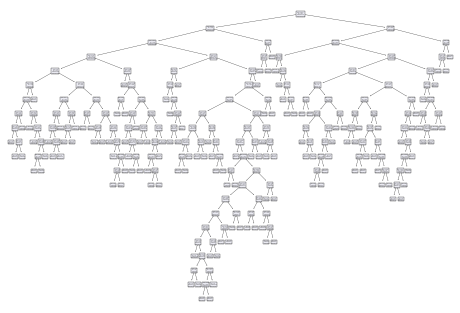

In [19]:
accuracy = treeAccuracy(5,0.3,all_data,True)

When training the decision trees, we withheld 30% of the data for testing. Now we can see how accurate our models are.

In [20]:
print("QB tree accuracy: " + str(round(accuracy[0]*100,3)) + "%")
print("RB tree accuracy: " + str(round(accuracy[1]*100,3)) + "%")
print("WR tree accuracy: " + str(round(accuracy[2]*100,3)) + "%")
print("TE tree accuracy: " + str(round(accuracy[3]*100,3)) + "%")

QB tree accuracy: 90.979%
RB tree accuracy: 92.64%
WR tree accuracy: 92.121%
TE tree accuracy: 92.619%


These classifiers are shockingly accurate.

As a side note, we noticed something interesting when training the decision trees. By playing around with the classification cutoff (top 10%, top 1%, etc), we found that the decision trees became less accurate when the cutoff was less extreme. It seems that there are distinct characteristics of outliers (both for extraordinarily low and extraordinarily high fantasy point scores). Note the code below takes about 1.5 minutes to run.


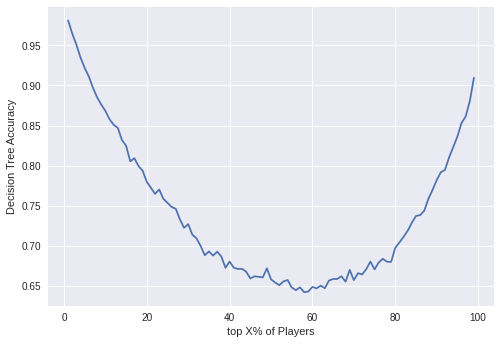

In [21]:
x = []
y = []
for i in range(1,100):
  temp = treeAccuracy(i, 0.3, all_data, False)
  y.append(np.mean(temp))
  x.append(i)


plt.plot(x,y);
plt.xlabel("top X% of Players")
plt.ylabel("Decision Tree Accuracy")
plt.show()

# Conclusion
It is a typical rookie mistake to draft a Quarterback first in a first fantasy football draft since you would think that they go and get the most points. Whether or not that may be true, it is important to consider the strength of a fantasy roster as a whole, and not just to look at one player or position.
While the data shows that Quarterbacks and Wide Receivers score higher than Running Backs often, the standard deviation for Running Backs shows that it is harder to obtain a Running Back that can score high points than it is for the other two positions.
The larger the standard deviation, the more players are separated from top-heavy scoring and bottom-heavy scoring, meaning that if you miss out on Running Backs that are top players, you will most likely be stuck with Running Backs that do not score high points which could be very damaging to your team.
As a result, it is more important to draft a top Running Back for your first pick in a fantasy draft than it is to draft a Wide Receiver or Quarterback since those other positions have more options for potential high scorers.

Additionally, we learned that it is possible to predict whether a player will be in the top bracket of their position next season, given stats about how they performed this season. Our decision tree for doing this can help users trying to build a fantasy football roster make a more educated decision about which players to select. This model is remarkably robust (and not overfit), as high accuracy can be found even when witholding 80% of the data for testing. It is quite fascinating that there are such clear predictive indicators of outlier performance.